In [53]:
%load_ext autoreload
%autoreload 2

import os, yaml
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as tvm
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import clip

from utils import dict2namespace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
c = torch.ones(10) * 0.5
torch.bernoulli(c).unsqueeze(-1).expand(10, 2)

tensor([[1., 1.],
        [0., 0.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [0., 0.],
        [1., 1.],
        [0., 0.],
        [0., 0.],
        [1., 1.]])

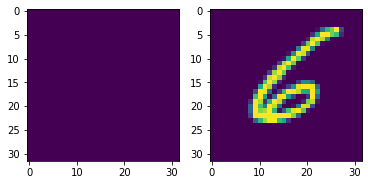

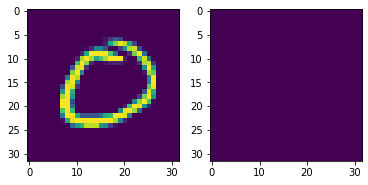

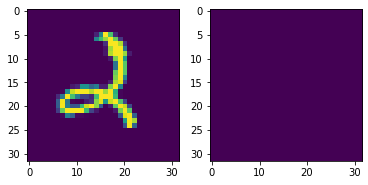

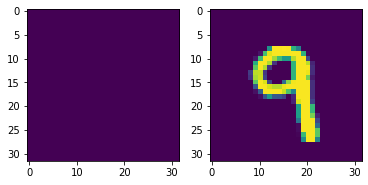

AssertionError: 

In [11]:
from lib.dataset import DataLooper

# Load config
config_path = './configs/antimnist.yml'
with open(config_path, 'r') as f:
    config_dict = yaml.safe_load(f)
config = dict2namespace(config_dict)

# Data Check
looper = DataLooper(
    config,
    batch_size=1,
    mode='train',
)

count = 0
for x, y in looper:
    fig = plt.figure()
    ax = fig.add_subplot(121)
    ax.imshow(x[0].permute(1, 2, 0))
    ax = fig.add_subplot(122)
    ax.imshow(y[0].permute(1, 2, 0))
    plt.show()
    count += 1
    if count > 3:
        assert 0==1

In [6]:
device = 'cuda:0'
clip_model = clip.load('ViT-B/16', jit=False)[0].eval().requires_grad_(False).to(device)
clip_size = clip_model.visual.input_resolution
normalize = T.Normalize(
    mean=[0.48145466, 0.4578275, 0.40821073],
    std=[0.26862954, 0.26130258, 0.27577711]
)

In [23]:
clip_model.visual.transformer.resblocks[0].attn.__dict__

{'training': False,
 '_parameters': OrderedDict([('in_proj_weight',
               Parameter containing:
               tensor([[-0.0002,  0.0268, -0.0010,  ..., -0.0179, -0.0128,  0.0003],
                       [ 0.0638,  0.0078,  0.0008,  ..., -0.0288, -0.0222, -0.0140],
                       [-0.0345,  0.0409, -0.0006,  ...,  0.0058,  0.0077, -0.0119],
                       ...,
                       [ 0.0006, -0.0223, -0.0035,  ...,  0.0043,  0.0027, -0.0010],
                       [-0.0173,  0.0056, -0.0168,  ..., -0.0467, -0.0431, -0.0040],
                       [-0.0066,  0.0112, -0.0085,  ..., -0.0362, -0.0329,  0.0123]],
                      device='cuda:0', dtype=torch.float16)),
              ('q_proj_weight', None),
              ('k_proj_weight', None),
              ('v_proj_weight', None),
              ('in_proj_bias',
               Parameter containing:
               tensor([-0.9385, -1.1914, -0.5112,  ..., -0.0396,  0.1420,  0.0565],
                      dev

In [26]:
class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)

    
class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(*[
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x
    
m = ResidualAttentionBlock(d_model=768, n_head=64)
m

TypeError: dict is not a Module subclass